In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import seaborn
import sys
import scipy.stats as stt

seaborn.set(font_scale=2,style='ticks')
clrs = seaborn.color_palette(n_colors=6)
sys.path.append("/Users/yves/Documents/Code/veronika_data/code_for_data_session/")

In [2]:
import functions as fv

# Load data and do a bunch of random stuff

In [3]:
dat = fv.load_organised_data()

In [4]:
design_matrix_HP, firing_rates_HP, design_matrix_PFC, firing_rates_PFC, time_ms, ind_init, ind_choice, ind_outcome = dat

In [48]:
#Describe the design matrix
desc = ['Latent_state',
       'Choices' ,
       'Outcomes',
       'Forced_trials',
       'Block', 
       'Task',
       'A' ,
       'B' ,
       'I' ,
       'Chosen Q value' ,
       'Chosen cross-term Q value',
       'Value A' ,
       'Value B' ,
       #'Value A',
       'Constant']

In [462]:
def cc_pval(x,y,n_shuff=5000):
    """ get correlation coefficient and p value for that correlation based on shuffle"""

    x = np.array(x); y= np.array(y)
    gIxs = np.where(np.logical_and(np.isfinite(x),np.isfinite(y)))[0]
    cc = np.corrcoef(x[gIxs],y[gIxs])[0,1]

    shuff_cc = []
    for _ in range(n_shuff):
        shuff_cc.append(np.corrcoef(x[gIxs],np.random.permutation(y[gIxs]))[0,1])

    return cc, stt.percentileofscore(shuff_cc,cc)

In [7]:
def plot_inds(ind_init=25,ind_choice=35,ind_outcome=42):
    plt.axvline(x=ind_init,color=clrs[0],dashes=(7,7))
    plt.axvline(x=ind_choice,color=clrs[1],dashes=(7,7))
    plt.axvline(x=ind_outcome,color=clrs[2],dashes=(7,7))


In [8]:
def get_block_transitions(DM,desc):
    
    task_nr = DM[:,desc.index('Task')]
    
    task_trans = [0,int(np.min(np.where(task_nr==2))),int(np.min(np.where(task_nr==3)))]
    
    tmp = DM[:,desc.index('Latent_state')]
    block_trans = np.concatenate([[0],1 + np.where(np.abs(tmp[1:] - tmp[:-1]))[0]])
    
    block_trans = [i for i in block_trans if i!=DM.shape[0]]
    

    blockL = []
    for st,nd in zip(block_trans[:-1],block_trans[1:]):
        blockL.append(nd-st)

    blockL.append(nTrials - block_trans[-1])
    t_in_block = np.concatenate([np.arange(i) for i in blockL])
    t_in_block_norm = np.concatenate([np.arange(i)/float(i) for i in blockL])
    return np.array(task_trans), block_trans, blockL, t_in_block, t_in_block_norm

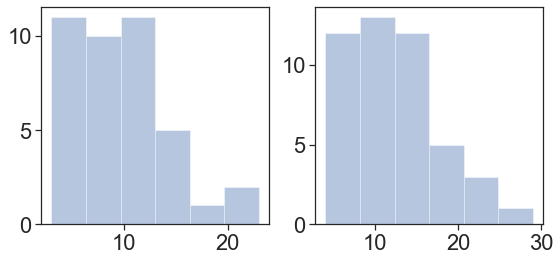

In [9]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
seaborn.distplot([i.shape[1] for i in firing_rates_HP],kde=0)

plt.subplot(1,2,2)
seaborn.distplot([i.shape[1] for i in firing_rates_PFC],kde=0)


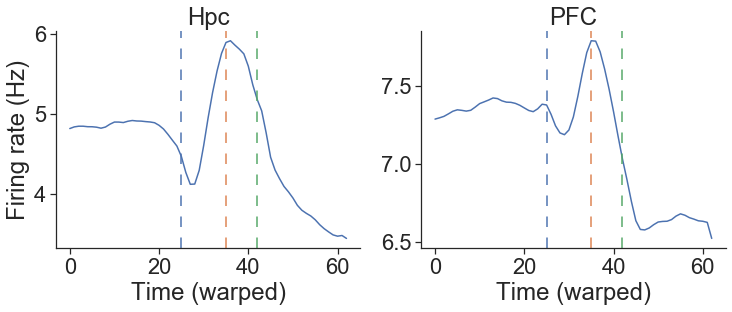

In [10]:
#Average firing rates across all data
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Hpc")
plt.plot(np.mean(np.array([np.mean(i,axis=(0,1)) for i in firing_rates_HP]),axis=0))
plt.axvline(x=ind_init,color=clrs[0],dashes=(7,7))
plt.axvline(x=ind_choice,color=clrs[1],dashes=(7,7))
plt.axvline(x=ind_outcome,color=clrs[2],dashes=(7,7))
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Time (warped)")

plt.subplot(1,2,2)
plt.title("PFC")
plt.plot(np.mean(np.array([np.mean(i,axis=(0,1)) for i in firing_rates_PFC]),axis=0))
plt.axvline(x=ind_init,color=clrs[0],dashes=(7,7))
plt.axvline(x=ind_choice,color=clrs[1],dashes=(7,7))
plt.axvline(x=ind_outcome,color=clrs[2],dashes=(7,7))
plt.xlabel("Time (warped)")

seaborn.despine()

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=20)

In [13]:
out = pca.fit_transform(np.vstack([j for i in firing_rates_PFC for j in i]))

In [14]:
pca.components_.shape

(20, 63)

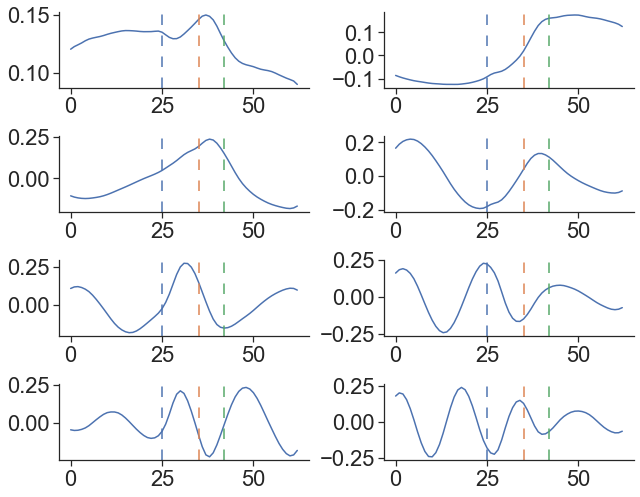

In [15]:
plt.figure(figsize=(9,7))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(pca.components_[i])
    plot_inds()
    
seaborn.despine()
plt.tight_layout()

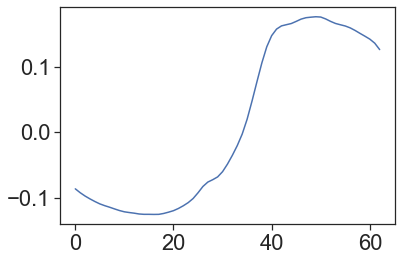

In [16]:
plt.plot(pca.components_[1])

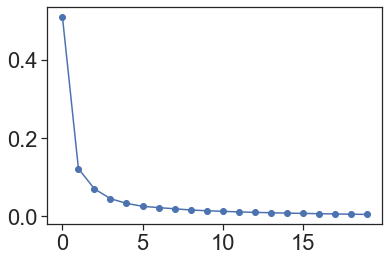

In [17]:
plt.plot(pca.explained_variance_ratio_,marker='o')

# Break down neural activity by trial type 

In [18]:
your_computer_path = '/Users/Yves/Documents/Code/veronika_data/'#'/Users/veronikasamborska/Desktop/'

dat = fv.load_trial_warped(your_computer_path)

In [19]:
sess_nr = 1

In [20]:
traces = firing_rates_PFC[sess_nr].swapaxes(0,1)
DM = design_matrix_PFC[sess_nr]
nTrials = DM.shape[0]

In [21]:
allReg = []
for t in traces:
    allReg.append(fv.regression_function(traces[0],DM))

# Plan is to do cross validation to check that there is real variance explained 

In [23]:
from sklearn.model_selection import RepeatedKFold
import sklearn.linear_model as lm

In [40]:
#basis functions for time in session. 
#(i.e. to allow different parameters to influence neural activity at each time point)
#This formula is used in the ugly_build_DM function
BF = np.vstack([stt.norm(loc=i,scale=2).pdf(np.arange(0,63)) for i in np.arange(0,63,6)])
nBF = BF.shape[0]

Text(0.5, 0, 'Time (warped)')

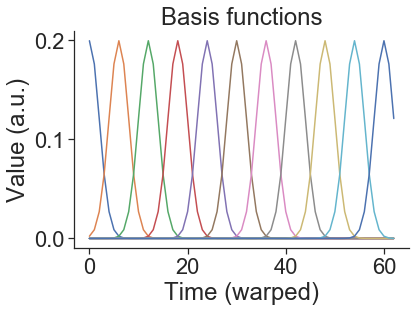

In [41]:
plt.title("Basis functions")
plt.plot(BF.T)
seaborn.despine()
plt.ylabel("Value (a.u.)")
plt.xlabel("Time (warped)")

In [93]:
def ugly_build_DM(DM):
    """ Really ugy function that builds the design matrix"""
    
    #pretty random basis function set (i.e. number and scale selected randomly)
    BF = np.vstack([stt.norm(loc=i,scale=2).pdf(np.arange(0,63)) for i in np.arange(0,63,6)])
    nBF = BF.shape[0]
    
    bigDM = []
    #for each trial
    for dm in DM:
        
        tmp = [] #tmp will hold the design matrix for that trials
        
        #for each regressor in that trial
        for reg in dm[:-1]:
            #scale the basis functions (time in trial) by the value 
            #of the regressors
            tmp.append(BF*reg)
        bigDM.append(np.vstack(tmp))

    bigDM = np.array(bigDM).swapaxes(0,1)
    return bigDM

In [146]:
np.arange(0,63,6).shape

(11,)

In [87]:
def fit_sess_tib(traces,bigDM,desc,nBF,ALFA=1.,nBF_T=1,seed=99):
    """ Fit LM to behavioral session fitting seperately with time in block
        and without time in block (tib)
        
        
    """
    ccs = []
    ccs_tib = []
    all_coef = []
    
    #for each neuron
    for nn in range(traces.shape[0]):
        
        y = traces[nn] #get traces
        
        ccx = []; ccx_tib = []; cfTB = [] #initialise contained for storing cross validated fits
        
        kf = RepeatedKFold(n_splits=5,n_repeats=2,random_state=seed)  #initialise repeated K-Fold
        
        
        for train_ix,test_ix in kf.split(y):  

            y_train = y[train_ix]; y_test = y[test_ix] #get train and test indices for activity
            
            #get train and test DM without time in block (i.e remove time in block regressors)
            x_train = bigDM[nBF_T*nBF:][:,train_ix]; x_test = bigDM[nBF_T*nBF:][:,test_ix]
            
            #get train and test DM with time in block
            x_train_tib = bigDM[:,train_ix]; x_test_tib = bigDM[:,test_ix]

            #fit linear model with regularisation. Ideally would do nested K-fold
            #to select optimal hyper-parameter
            linR = lm.Ridge(alpha=ALFA,fit_intercept=True)
            
            x_ = x_train.reshape([nRegs-nBF_T*nBF,-1]).T  #flatten regressors (without time in block) across trials (training set)
            ft = linR.fit(x_,y_train.flatten())

            xt_ = x_test.reshape(nRegs-nBF_T*nBF,-1).T    #flatten regressors (without time in block) across trials (test set)
            
            ccx.append(np.corrcoef(ft.predict(xt_),y_test.flatten())[0,1])  #get cross validated fit quality

            linR = lm.Ridge(alpha=ALFA,fit_intercept=True)
            x_ = x_train_tib.reshape([nRegs,-1]).T
            ft = linR.fit(x_,y_train.flatten())
            xt_ = x_test_tib.reshape(nRegs,-1).T
            ccx_tib.append(np.corrcoef(ft.predict(xt_),y_test.flatten())[0,1])
            cfTB.append(ft.coef_)


        ccs.append(np.mean(ccx))
        ccs_tib.append(np.mean(ccx_tib))
        all_coef.append(np.mean(cfTB,axis=0))
    return np.array(ccs),np.array(ccs_tib),all_coef

In [88]:
#place cell code for normalized time in block. By parameterising these as functions, you can flexibly deal with
#different numbers of trials in different blocks. See below
BFs_time = [stt.norm(loc=i,scale=.2) for i in np.linspace(0,1,num=3)] #basis functions for time in session

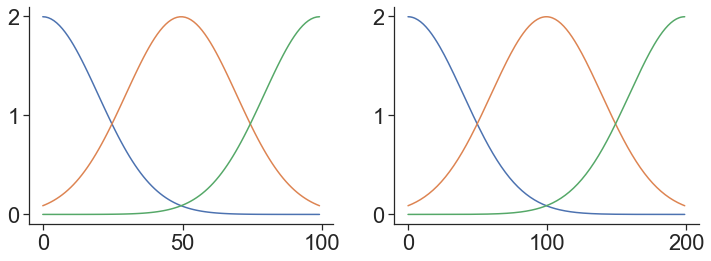

In [520]:
plt.figure(figsize=(12,4))

#assume that there are 100 trials in the block for pretend
plt.subplot(1,2,1)
for i in BFs_time:
    plt.plot(i.pdf(np.linspace(0,1,num=100)))

#now pretend there are 200 trials in the block, see that BFs interpolate
plt.subplot(1,2,2)
for i in BFs_time:
    plt.plot(i.pdf(np.linspace(0,1,num=200)))
seaborn.despine()

In [214]:
firing_rates_set = firing_rates_PFC.copy(); DM_set = design_matrix_PFC.copy()
#firing_rates_set = firing_rates_HP.copy(); DM_set = design_matrix_HP.copy()

#DM_set = design_matrix_PFC.copy()

#initialise placeholders
all_ccs = []; all_ccs_tib = []; all_coef = []


#loop over sessions
for sess_nr in range(len(firing_rates_set)):
    sys.stdout.write("\r%s / %s" %(sess_nr,len(firing_rates_set)))
    sys.stdout.flush()
    traces = firing_rates_set[sess_nr].swapaxes(0,1)
    DM = DM_set[sess_nr]
    nTrials = DM.shape[0]
    
        
    task_trans, block_trans, blockL,_, t_in_block = get_block_transitions(DM,desc)
    
    T = t_in_block  #linear time in each block
    
    ##place cell code for time in block, if use this instead of T, need to change the number of 
    #time basis functions to be num_basis_funcs * 2 (for each block type)
    #T = np.array([i.pdf(t_in_block) for i in BFs_time])    
    
    #two basis functions for time (one for each block).
    Tdim = 2*(1 if np.ndim(T)==1 else T.shape[0])

    DM_3 = np.vstack([T*DM[:,0],  #separate time values for the different blocks
                      T*(DM[:,0]==0),
                      DM.T]).T

    bigDM = ugly_build_DM(DM_3)  #build the full design matrix bigDM.shape = (num_regressors, num_trials, num_timepoints)
    nRegs = bigDM.shape[0]  #total number of regressors

    ccs,ccs_tib,coef = fit_sess_tib(traces,bigDM,desc,nBF,nBF_T=Tdim)
    
    
    #store correlations on test set with and without time in block 
    #as well as the linear regression coefficients
    all_ccs.append(ccs)
    all_ccs_tib.append(ccs_tib)
    all_coef.append(coef)

8 / 46

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


45 / 46

In [493]:
#stack across sessions and calculate r2 for each neuron
c1 = np.concatenate(all_ccs)**2
c2 = np.concatenate(all_ccs_tib)**2

ixs = np.logical_and.reduce([np.isfinite(c1),  #deal with failure (unknown for some neurons where code returns nan)
                             np.isfinite(c2),
                             c1>.01,c2>.01])
t,p = stt.ttest_rel(c1[ixs],c2[ixs])
print('Variance explained \nwithout time in block: {:.5f}\nwith time in block: {:.5f}'.format(np.nanmean(c1),np.nanmean(c2)))
print('t:{:.3f}\np:{:.3e}'.format(t,p))

Variance explained 
without time in block: 0.18936
with time in block: 0.18989
t:-5.050
p:6.053e-07


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


# Now see that regression coefficients for different block types are anti-correlated 

In [510]:
#add small term to ensure don't include noise. Can probably do this cleaner.
ixs2 = (c1<=(c2-10e-4))

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


In [511]:
offs = 2     #ignore the first offs basis functions for time in block
end_rem = 5  #ignore the final end_rem basis functions for time in block
a1 = np.concatenate([np.mean(np.array(i)[:,offs:11-end_rem],axis=1) for i in all_coef])
a2 = np.concatenate([np.mean(np.array(i)[:,11+offs:22-end_rem],axis=1) for i in all_coef])
np.corrcoef(a1[ixs2],a2[ixs2])

array([[ 1.        , -0.38991856],
       [-0.38991856,  1.        ]])

In [512]:
np.corrcoef(a1[ixs2],a2[ixs2])

array([[ 1.        , -0.38991856],
       [-0.38991856,  1.        ]])

In [513]:
sys.path.append('/Users/yves/Documents/Code/')

In [514]:
cc,percentile_of_shuff = cc_pval(a1[ixs2],a2[ixs2],)
print('correlation coefficient: {:.3f}\np_value: {:.4f}'.format(cc,percentile_of_shuff/100.))

correlation coefficient: -0.390
p_value: 0.0000


Text(10.0, 0.5, "Weights for 'b' block")

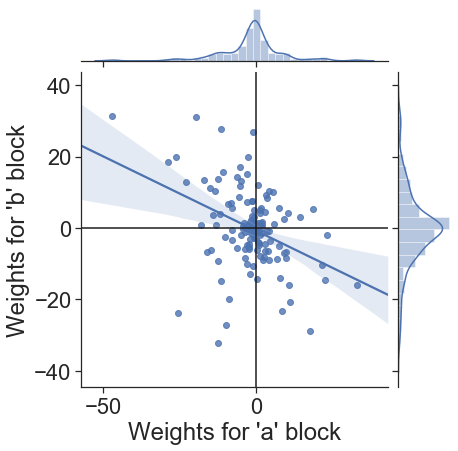

In [515]:
seaborn.jointplot(a1[ixs2],a2[ixs2],kind='reg')
#plt.plot([-1,1],[0,0])
plt.axhline(y=0,color='k')
plt.axvline(x=0,color='k')
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.xlabel("Weights for 'a' block")
plt.ylabel("Weights for 'b' block")


In [368]:
c1 = np.concatenate(all_ccs)**2
c2 = np.concatenate(all_ccs_tib)**2

ixs = np.logical_and.reduce([np.isfinite(c1),
                             np.isfinite(c2),
                             c1>.05,c2>.05])
t,p = stt.ttest_rel(c1[ixs],c2[ixs])
print(t,p)

-5.013642528267075 7.559131749962561e-07


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [369]:
np.nanmean(c1[ixs])

0.2231591835751838

In [370]:
np.nanmean(c2[ixs])

0.22375505789189193

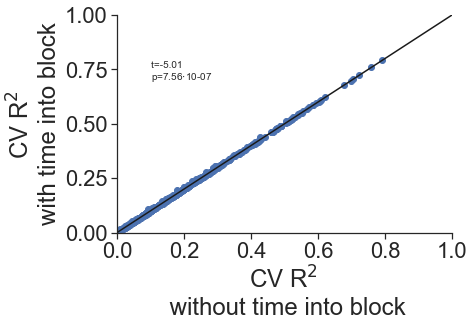

In [371]:
plt.scatter(c1,c2)
plt.plot([0,1],[0,1],color='k')
plt.xlim(0,1)
plt.ylim(0,1)
plt.annotate('t={:.2f} \np={:.2e}'.format(t,p).replace('e','$\cdot$10'),(.1,.7))
plt.xlabel("CV R$^2$ \n without time into block")
plt.ylabel("CV R$^2$ \nwith time into block")
seaborn.despine()

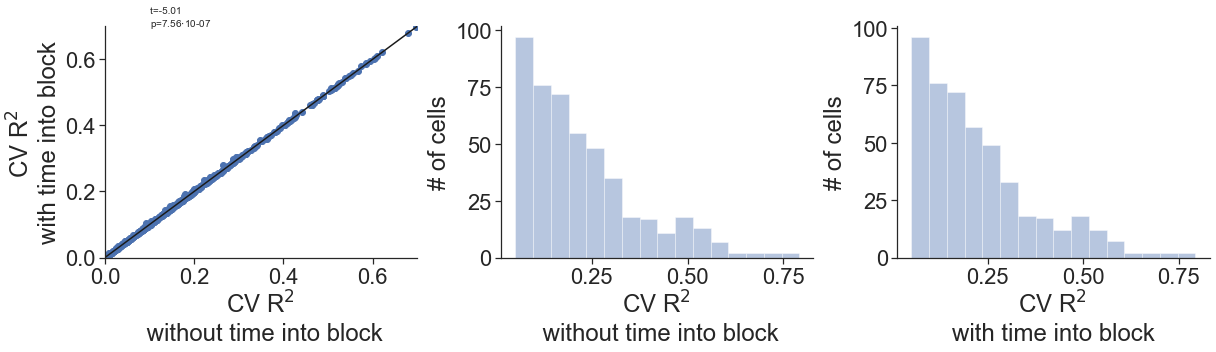

In [372]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.scatter(c1,c2)
plt.plot([0,1],[0,1],color='k')
plt.xlim(0,.7)
plt.ylim(0,.7)
plt.annotate('t={:.2f} \np={:.2e}'.format(t,p).replace('e','$\cdot$10'),(.1,.7))
plt.xlabel("CV R$^2$ \n without time into block")
plt.ylabel("CV R$^2$ \nwith time into block")
plt.subplot(1,3,2)
seaborn.distplot(c1[ixs],kde=0)
plt.ylabel("# of cells")
plt.xlabel("CV R$^2$ \n without time into block")

plt.subplot(1,3,3)
seaborn.distplot(c2[ixs],kde=0)
plt.ylabel("# of cells")
plt.xlabel("CV R$^2$ \nwith time into block")


seaborn.despine()
plt.tight_layout()
#plt.savefig("/Users/yves/Documents/Code/veronika_data/figs/cvr2_hpc.png")
#plt.savefig("/Users/yves/Documents/Code/veronika_data/figs/cvr2_hpc.svg")


In [1452]:
stt.ttest_rel(np.concatenate(all_ccs),np.concatenate(all_ccs_tib))

Ttest_relResult(statistic=nan, pvalue=nan)

In [1029]:
np.mean(ccs_tib)

0.3402594216724032

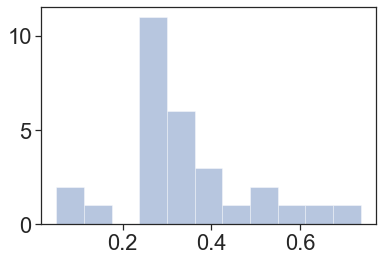

In [1391]:
seaborn.distplot(ccs,kde=0)

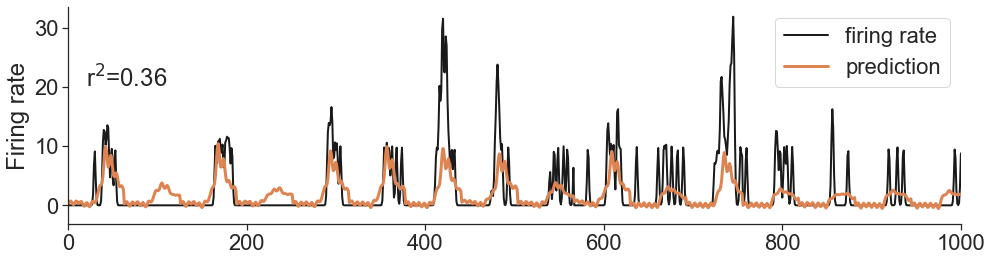

In [1492]:
plt.figure(figsize=(16,4))
plt.plot(y_test.flatten(),color='k',label='firing rate',linewidth=2)
plt.plot(ft.predict(xt_),color=clrs[1],label='prediction',linewidth=3)
plt.annotate('r$^2$=0.36',(20,20))
plt.xlim(0,1000)
plt.ylabel("Firing rate")
plt.legend()
seaborn.despine()
#plt.savefig("/Users/yves/Documents/Code/veronika_data/figs/eg_pred_hp_clu.png")
#plt.savefig("/Users/yves/Documents/Code/veronika_data/figs/eg_pred_hp_clu.svg")


In [1474]:
np.corrcoef(y_test.flatten(),ft.predict(xt_))[0,1]**2

0.3613017761645261

# Now try the manifold hypothesis